# **Feature Engineering**

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
#from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from tqdm.notebook import tqdm
from sklearn.impute import KNNImputer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/Case_study_1/original_csv_files/csv_files")
files = os.listdir()

# **knn imputation**

In [ ]:
member = pd.read_csv('members_1.csv')
print(member.shape)
member.head(3)

(34403, 7)


,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712


In [ ]:
# make zero age to nan because we know that any user not have zero age.EX-if age <= 0 than age = np.nan.
# make large age to 80. EX- if age > 80 than age = 80.
def age_replace(data):

    new_age = []
    for i in data['bd'].values:
        if i <= 0 :
            new_age.append(np.nan)
        elif i > 55 :
            new_age.append(55)
        elif i > 60:
            new_age.append(np.nan)
        else :
            new_age.append(i)
    data['new_bd'] = new_age
    return data

def get_d_m_y(sample_data):

    regi_date = sample_data['registration_init_time'].values
    expi_date = sample_data['expiration_date'].values

    day   = []
    month = []
    year  = []

    for i in regi_date:
        i = str(i)
        day.append(int(i[:4]))
        month.append(int(i[4:6]))
        year.append(int(i[6:]))
    sample_data['regi_day']   = day
    sample_data['regi_month'] = month
    sample_data['regi_year']  = year

    day   = []
    month = []
    year  = []

    for i in expi_date:
        i = str(i)
        day.append(int(i[:4]))
        month.append(int(i[4:6]))
        year.append(int(i[6:]))
    sample_data['expire_day']   = day
    sample_data['expire_month'] = month
    sample_data['expire_year']  = year

    sample_data = sample_data.drop(['expiration_date','registration_init_time'],axis =1)

    return sample_data


In [ ]:
member = age_replace(member)
member = get_d_m_y(member)
print(member.shape)
member.head(3)

(34403, 12)


,msno,city,bd,gender,registered_via,new_bd,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,NaN,2011,8,20,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,NaN,2015,6,28,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,NaN,2016,4,11,2017,7,12


In [ ]:
new_data = member[['city','new_bd','registered_via' , 'regi_day' ,'regi_month' , 'regi_year' ,'expire_day','expire_month' ,'expire_year' ]]
print(new_data.shape)
new_data.head(3)

(34403, 9)


,city,new_bd,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year
0,1,NaN,7,2011,8,20,2017,9,20
1,1,NaN,7,2015,6,28,2017,6,22
2,1,NaN,4,2016,4,11,2017,7,12


In [ ]:
imputer = KNNImputer(n_neighbors=10)
imputer.fit(new_data)

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=10, weights='uniform')

In [ ]:
start = time.time()
X = imputer.transform(new_data)
print((time.time() - start) /  60)

0.5658482670783996


In [ ]:
for i in range(len(new_data.columns)):
    new_data[new_data.columns[i]] = X[:,i]
print(new_data.shape)
new_data.head(3)

(34403, 9)


,city,new_bd,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year
0,1.0,31.7,7.0,2011.0,8.0,20.0,2017.0,9.0,20.0
1,1.0,26.3,7.0,2015.0,6.0,28.0,2017.0,6.0,22.0
2,1.0,28.2,4.0,2016.0,4.0,11.0,2017.0,7.0,12.0


### **Before Imputation of bd**

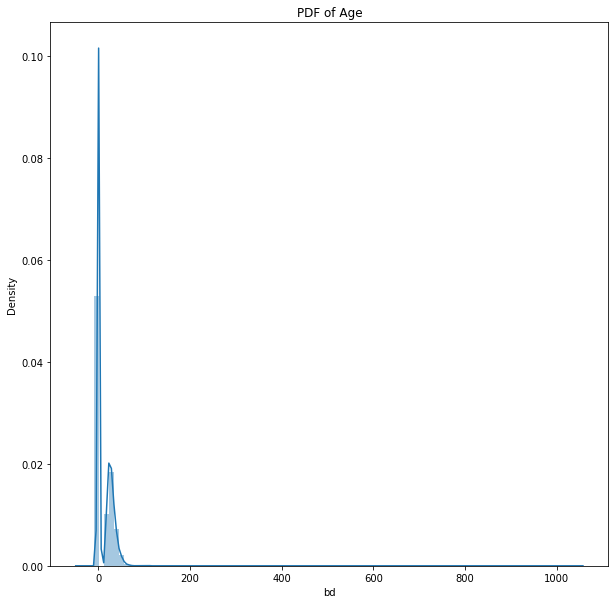

In [ ]:
plt.figure(figsize = (10,10))
ax = sns.distplot(member['bd'], bins = 100,hist = True)
#h,l = ax.get_legend_handles_labels()
#ax.legend(h ,l,bbox_to_anchor=(1.05, 1) ,loc = 'upper left')
#plt.setp(ax.get_xticklabels() , rotation = 90 )
plt.title('PDF of {}'.format("Age"))
plt.show()

### **After Imputation of bd**

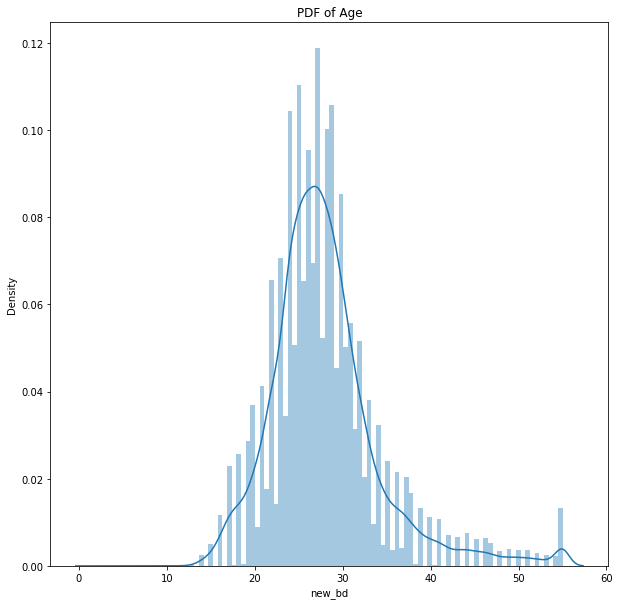

In [ ]:
plt.figure(figsize = (10,10))
ax = sns.distplot(new_data['new_bd'], bins = 100,hist = True)
#h,l = ax.get_legend_handles_labels()
#ax.legend(h ,l,bbox_to_anchor=(1.05, 1) ,loc = 'upper left')
#plt.setp(ax.get_xticklabels() , rotation = 90 )
plt.title('PDF of {}'.format("Age"))
plt.show()

In [ ]:
member['imputed_bd'] = new_data['new_bd']
print(member.shape)

(34403, 13)


In [ ]:
member = member.drop('new_bd',axis = 1)
print(member.shape)
member.head(3)

(34403, 12)


,msno,city,bd,gender,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011,8,20,2017,9,20,31.7
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015,6,28,2017,6,22,26.3
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016,4,11,2017,7,12,28.2


In [ ]:
member.to_csv('new_member.csv')

In [4]:
# function for remove columns which name start with 'Unnamed:'
# input  : dataframe
# output : dataframe without 'Unnamed:' columns
def remove_funtion(data):
    for i in data.columns:
        if i.split()[0] == 'Unnamed:':
            data = data.drop(i,axis = 1)
    return data

# function for find unique values 
# input  : dataframe
# output : list of unique values in each columns of dataframe
def info(data):
    
    columns_name = list(data.columns)
    print('columns_name',' '*(10),'unique_values' , ' '*(7),'Type' )
    print('-'*50)
    
    for name in columns_name:
        length = str(len(list(set(data[name].values)))) 
        print(name ,(25-len(name))*' ','|', length ,(10 - len(length) )*' ','|', data[name].dtype) 
    print('_'*50)
    return 

# function for find missing value
# input  : dataframe
# output : percentage of missing value in each columns
def find_missing_values(songs_info):
    print('='*30)
    print('Shape of file :',songs_info.shape)
    print('='*30)
    print('columns_name',' '*(7),'missing_values in %')

    print('-'*30)
    
    columns_name = list(songs_info.columns)
    for name in columns_name:
        null_value = sum(songs_info[name].isnull())
        percentage = (null_value * 100) / songs_info.shape[0]
        print(name ,(25-len(name))*' ',':', percentage) 
    print('='*30)
    return

# **Merge all files**

In [7]:
# merge data
member = pd.read_csv('new_member.csv')
print('member shape :',member.shape)

train = pd.read_csv('train_1.csv')
print('train shape :',train.shape)

song_extra_info = pd.read_csv('song_extra_info_1.csv')
print('song_extra_info shape :',song_extra_info.shape)

songs = pd.read_csv('songs_1.csv')
print('songs shape :' , songs.shape)

songs_info = songs.merge(song_extra_info, how='left', on='song_id')
train_member = train.merge(member , how = 'left' , on = 'msno')
train_data = train_member.merge(songs_info, how='left', on='song_id')
print('train_data shape :',train_data.shape)

member shape : (34403, 13)
train shape : (7377418, 6)
song_extra_info shape : (2295971, 3)
songs shape : (2296320, 7)
train_data shape : (7377418, 26)


In [ ]:
test = pd.read_csv('test_1.csv')
print('test shape :',test.shape)

# merge data on test file
test_member = test.merge(member , how = 'left' , on = 'msno')
test_data = test_member.merge(songs_info, how='left', on='song_id')
print('test data shape :',test_data.shape)

test shape : (2556790, 6)
test data shape : (2556790, 26)


In [ ]:
train_data = remove_funtion(train_data)
print(train_data.shape)
train_data.head(3)

(7377418, 25)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,2012,1,2,2017,10,5,28.3,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,5,25,2017,9,11,24.0,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,5,25,2017,9,11,24.0,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761


In [ ]:
test_data = remove_funtion(test_data)
print(test_data.shape)
test_data.head(3)

(2556790, 25)


,id,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,NaN,7,2016,2,19,2017,9,18,21.3,224130.0,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0,愛其實很殘忍,TWUM71400047
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,1,0,NaN,7,2016,2,19,2017,9,18,21.3,320470.0,465,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,3.0,她說,TWB671005201
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,1,0,NaN,4,2016,11,17,2016,11,24,25.5,315899.0,2022,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,17.0,subarashiki nichijo,JPWP01070260


# **train_test_split**

In [ ]:
print(train_data.shape)
print(test_data.shape)

(7377418, 25)
(2556790, 25)


In [ ]:
split_val = round((80 * 7377418) / 100)
split_val

5901934

In [ ]:
# split data
val_data   = train_data[split_val:]
train_data = train_data[:split_val]

print(train_data.shape , val_data.shape , test_data.shape)

(5901934, 25) (1475484, 25) (2556790, 25)


In [ ]:
# seprate genre_ids and make seprate columns for each genre_ids
def separate_genre(data):
    genre = data['genre_ids'].values
    genre_category  = []

    # seprate all genre and store in genre_category
    for i in genre:
        lis = []
        i = str(i)
        if '|' in i:
            sen = i.split('|')
            genre_category.append(sen)
        else:
            lis.append(i)
            genre_category.append(lis)
    # if len(genre) < 8 than fill 0 to make all len(genre) == 8        
    genre_id_list = []
    for i in genre_category:
        while len(i) < 8:
            i.append(0)
        genre_id_list.append(i)

    genre_ids = np.array(genre_id_list)

    # make seprate columns for all genre_ids 
    data['one_genre']   = genre_ids[:,0]
    data['two_genre']   = genre_ids[:,1] 
    data['three_genre'] = genre_ids[:,2]
    data['four_genre']  = genre_ids[:,3]
    data['five_genre']  = genre_ids[:,4]
    data['six_genre']   = genre_ids[:,5]
    data['seven_genre'] = genre_ids[:,6]
    data['eight_genre'] = genre_ids[:,7]

    data = data.drop('genre_ids' , axis = 1)

    return data

In [ ]:
train_data = separate_genre(train_data)
val_data   = separate_genre(val_data)
test_data  = separate_genre(test_data)


In [ ]:
print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 32)
Vali  Shape : (1475484, 32)
Test  shape : (2556790, 32)


# Feature Engineering

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

In [ ]:
find_missing_values(train_data)
info(train_data)

Shape of file : (5901934, 32)
columns_name         missing_values in %
------------------------------
msno                       : 0.0
song_id                    : 0.0
source_system_tab          : 0.3391769545372754
source_screen_name         : 5.459972951239373
source_type                : 0.2842288646399638
target                     : 0.0
city                       : 0.0
bd                         : 0.0
gender                     : 39.76235586504356
registered_via             : 0.0
regi_day                   : 0.0
regi_month                 : 0.0
regi_year                  : 0.0
expire_day                 : 0.0
expire_month               : 0.0
expire_year                : 0.0
imputed_bd                 : 0.0
song_length                : 0.001660472651845988
artist_name                : 0.001660472651845988
composer                   : 22.635783456744857
lyricist                   : 42.84673464664295
language                   : 0.0021348934095162704
name                       : 0.01

In [ ]:
find_missing_values(val_data)
info(val_data)

Shape of file : (1475484, 32)
columns_name         missing_values in %
------------------------------
msno                       : 0.0
song_id                    : 0.0
source_system_tab          : 0.32741798623366974
source_screen_name         : 6.27319577846998
source_type                : 0.32287710337760356
target                     : 0.0
city                       : 0.0
bd                         : 0.0
gender                     : 41.66300685063342
registered_via             : 0.0
regi_day                   : 0.0
regi_month                 : 0.0
regi_year                  : 0.0
expire_day                 : 0.0
expire_month               : 0.0
expire_year                : 0.0
imputed_bd                 : 0.0
song_length                : 0.001084389935777006
artist_name                : 0.001084389935777006
composer                   : 23.026816963111767
lyricist                   : 44.0541544333927
language                   : 0.001626584903665509
name                       : 0.037

In [ ]:
find_missing_values(test_data)
info(test_data)

Shape of file : (2556790, 32)
columns_name         missing_values in %
------------------------------
id                         : 0.0
msno                       : 0.0
song_id                    : 0.0
source_system_tab          : 0.33017963931335775
source_screen_name         : 6.3706053293387415
source_type                : 0.28539692348608997
city                       : 0.0
bd                         : 0.0
gender                     : 41.15410338745067
registered_via             : 0.0
regi_day                   : 0.0
regi_month                 : 0.0
regi_year                  : 0.0
expire_day                 : 0.0
expire_month               : 0.0
expire_year                : 0.0
imputed_bd                 : 0.0
song_length                : 0.0009777885551805192
artist_name                : 0.0009777885551805192
composer                   : 24.221934535100655
lyricist                   : 47.901626649040395
language                   : 0.0016426847727032724
name                       

In [ ]:
# replace missing value with mode
mode_system_tab  = str(train_data[ 'source_system_tab'].mode()[0])
mode_source_type = str(train_data['source_type'].mode()[0])
mode_name        = str(train_data['name'].mode()[0])
mode_artist_name = str(train_data['artist_name'].mode()[0])
mode_language    = str(train_data['language'].mode()[0])

print( 'Mode of source_system_tab :',mode_system_tab)
print( 'Mode of source_type       :',mode_source_type)
print( 'Mode of name              :',mode_name)
print( 'Mode of artist_name       :',mode_artist_name)
print( 'Mode of language          :',mode_language)

Mode of source_system_tab : my library
Mode of source_type       : local-library
Mode of name              : 演員
Mode of artist_name       : Various Artists
Mode of language          : 3.0


# **Deal With Missing Values**

* If Missing value rate is < 1% than we will fill with mode of that feature.
* For Categorical feature we will define nan values as 'not_define' categories.
* For Numeric categorical feature we will fill with 0.
* For Numeric (continuous variable) values we will fill with median.

In [ ]:

# replace missing values with new category EX- for categorical data fill not_define and for numerical data fill zeros.
train_data['composer'] = train_data['composer'].fillna('no_name')
val_data['composer'] = val_data['composer'].fillna('no_name')
test_data['composer'] = test_data['composer'].fillna('no_name')

train_data['lyricist'] = train_data['lyricist'].fillna('no_name')
val_data['lyricist'] = val_data['lyricist'].fillna('no_name')
test_data['lyricist'] = test_data['lyricist'].fillna('no_name')

train_data['source_screen_name'] = train_data['source_screen_name'].fillna('not_define')
val_data['source_screen_name'] = val_data['source_screen_name'].fillna('not_define')
test_data['source_screen_name'] = test_data['source_screen_name'].fillna('not_define')

train_data['gender'] = train_data['gender'].fillna('not_define')
val_data['gender'] = val_data['gender'].fillna('not_define')
test_data['gender'] = test_data['gender'].fillna('not_define')

# for numeric feature
train_data['isrc'] = train_data['isrc'].fillna('0')
val_data['isrc'] = val_data['isrc'].fillna('0')
test_data['isrc'] = test_data['isrc'].fillna('0')

# replace missing values with mode 
train_data['source_system_tab'] = train_data['source_system_tab'].fillna(mode_system_tab)
val_data['source_system_tab'] = val_data['source_system_tab'].fillna(mode_system_tab)
test_data['source_system_tab'] = test_data['source_system_tab'].fillna(mode_system_tab)

train_data['source_type'] = train_data['source_type'].fillna(mode_source_type)
val_data['source_type'] = val_data['source_type'].fillna(mode_source_type)
test_data['source_type'] = test_data['source_type'].fillna(mode_source_type)

train_data['name'] = train_data['name'].fillna(mode_name)
val_data['name'] = val_data['name'].fillna(mode_name)
test_data['name'] = test_data['name'].fillna(mode_name)

train_data['song_length'] = train_data['song_length'].fillna(train_data['song_length'].median())
val_data['song_length'] = val_data['song_length'].fillna(train_data['song_length'].median())
test_data['song_length'] = test_data['song_length'].fillna(train_data['song_length'].median())

train_data['artist_name'] = train_data['artist_name'].fillna(mode_artist_name)
val_data['artist_name'] = val_data['artist_name'].fillna(mode_artist_name)
test_data['artist_name'] = test_data['artist_name'].fillna(mode_artist_name)

train_data['language'] = train_data['language'].fillna(mode_language)
val_data['language'] = val_data['language'].fillna(mode_language)
test_data['language'] = test_data['language'].fillna(mode_language)

In [ ]:
train_data.isnull().any()

msno                  False
song_id               False
source_system_tab     False
source_screen_name    False
source_type           False
target                False
city                  False
bd                    False
gender                False
registered_via        False
regi_day              False
regi_month            False
regi_year             False
expire_day            False
expire_month          False
expire_year           False
imputed_bd            False
song_length           False
artist_name           False
composer              False
lyricist              False
language              False
name                  False
isrc                  False
one_genre             False
two_genre             False
three_genre           False
four_genre            False
five_genre            False
six_genre             False
seven_genre           False
eight_genre           False
dtype: bool

In [ ]:
val_data.isnull().any()

msno                  False
song_id               False
source_system_tab     False
source_screen_name    False
source_type           False
target                False
city                  False
bd                    False
gender                False
registered_via        False
regi_day              False
regi_month            False
regi_year             False
expire_day            False
expire_month          False
expire_year           False
imputed_bd            False
song_length           False
artist_name           False
composer              False
lyricist              False
language              False
name                  False
isrc                  False
one_genre             False
two_genre             False
three_genre           False
four_genre            False
five_genre            False
six_genre             False
seven_genre           False
eight_genre           False
dtype: bool

In [ ]:
test_data.isnull().any()

id                    False
msno                  False
song_id               False
source_system_tab     False
source_screen_name    False
source_type           False
city                  False
bd                    False
gender                False
registered_via        False
regi_day              False
regi_month            False
regi_year             False
expire_day            False
expire_month          False
expire_year           False
imputed_bd            False
song_length           False
artist_name           False
composer              False
lyricist              False
language              False
name                  False
isrc                  False
one_genre             False
two_genre             False
three_genre           False
four_genre            False
five_genre            False
six_genre             False
seven_genre           False
eight_genre           False
dtype: bool

# **Feature Extraction**

In [ ]:
print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 32)
Vali  Shape : (1475484, 32)
Test  shape : (2556790, 32)


In [ ]:
''' make new feature : if song len < mean : 1, else: 0 '''
mean = train_data['song_length'].mean()
def song_len(sample_data):
    
    #print(mean)
    binary_feature = []
    #sample_data.head()

    song_len = sample_data['song_length'].values

    for i in song_len:
        if i < mean:
            binary_feature.append(1)
        else:
            binary_feature.append(0)
    sample_data['binary_song_length'] = binary_feature
    return sample_data

train_data = song_len(train_data)
val_data   = song_len(val_data)
test_data  = song_len(test_data)

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 33)
Vali  Shape : (1475484, 33)
Test  shape : (2556790, 33)


In [ ]:
# create new feature 
# if language = 3 or 52 than 1 else: 0
# we know that most song language are 3 or 52.
def like_language(sample_data):
    language = sample_data['language'].values
    like_language = []
    for i in language:
        if i == 3 or i == 52:
            like_language.append(1)
        else:
            like_language.append(0)
    sample_data['like_language'] = like_language
    return sample_data
    
train_data = like_language(train_data)
val_data   = like_language(val_data)
test_dat   = like_language(test_data)

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 34)
Vali  Shape : (1475484, 34)
Test  shape : (2556790, 34)


In [ ]:
#count how many name
def count_funtion(x,zero):

    if x != zero:
        split_lis = ['|',',','/','\\',';','、']
        sum = 0
        for i in split_lis:
            sum += x.count(i)
        return sum + 1
    else:
        return 0

In [ ]:
# create new feature : count of composer artist
train_composer_count = []
for i in train_data['composer']:
    s = count_funtion(i,'no_name')
    train_composer_count.append(s)
train_data['composer_count'] = train_composer_count

val_composer_count = []
for i in val_data['composer']:
    s = count_funtion(i,'no_name')
    val_composer_count.append(s)
val_data['composer_count'] = val_composer_count

test_composer_count = []
for i in test_data['composer']:
    s = count_funtion(i,'no_name')
    test_composer_count.append(s)
test_data['composer_count'] = test_composer_count

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 35)
Vali  Shape : (1475484, 35)
Test  shape : (2556790, 35)


In [ ]:
# create new feature : count of lyricist artist

train_lyricist_count = []
for i in train_data['lyricist']:
    s = count_funtion(i,'no_name')
    train_lyricist_count.append(s)
train_data['lyricist_count'] = train_lyricist_count

val_lyricist_count = []
for i in val_data['lyricist']:
    s = count_funtion(i,'no_name')
    val_lyricist_count.append(s)
val_data['lyricist_count'] = val_lyricist_count

test_lyricist_count = []
for i in test_data['lyricist']:
    s = count_funtion(i,'no_name')
    test_lyricist_count.append(s)
test_data['lyricist_count'] = test_lyricist_count

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 36)
Vali  Shape : (1475484, 36)
Test  shape : (2556790, 36)


In [ ]:
# funtion return how many genre_ids we have in each row 
genre = train_data['genre_ids'].values
max_genre = []

for i in genre:
    i = str(i)
    max_genre.append(len(i.split('|')))
    
for i in range(1,max(max_genre)+1):
    c = str(max_genre.count(i))
    print(c ,' '*(6-len(c))  , 'rows have' , i , 'genre_ids')

In [ ]:
# get first name of composer
def get_composer_name(sample_data):
    composer = sample_data['composer'].values
    composer_first_name = []
    for i in (composer):
        
        special = 0
        split_lis = ['|',',','\_','/','\\',';','、']
        
        #if any value of split_lis present in i than go in.
        if any((c in split_lis) for c in i):
            #check spliting character
            for j in split_lis:
                if j in i:
                    special = j
                    composer_first_name.append(i.split(special)[0])
                    #print(i.split(special)[0])
                    break
        else:
            composer_first_name.append(i)
            #print(i)

    sample_data['composer_first_name'] = composer_first_name
    return sample_data

train_data = get_composer_name(train_data)
val_data   = get_composer_name(val_data)
test_data  = get_composer_name(test_data)  

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 37)
Vali  Shape : (1475484, 37)
Test  shape : (2556790, 37)


In [ ]:
# get first name of artist_name
def get_artist_name(sample_data):
    artist_name = sample_data['artist_name'].values
    artist_name_first_name = []
    for i in (artist_name):
        i = str(i)
        special = 0
        split_lis = ['|',',','\_','/','\\',';','、']
        
        #if any value of split_lis present in i than go in.
        if any((c in split_lis) for c in i):
            #check spliting character
            for j in split_lis:
                if j in i:
                    special = j
                    artist_name_first_name.append(i.split(special)[0])
                    #print(i.split(special)[0])
                    break
        else:
            artist_name_first_name.append(i)
            #print(i)

    sample_data['first_artist_name'] = artist_name_first_name
    return sample_data

train_data = get_artist_name(train_data)
val_data   = get_artist_name(val_data)
test_data  = get_artist_name(test_data)  

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 38)
Vali  Shape : (1475484, 38)
Test  shape : (2556790, 38)


In [ ]:
# funtion for extract values from isrc feature
def extract_code(c):
    if c == '0':
        return 0,0,0,0
    else:
        return c[:2],c[2:5],c[5:7],c[7:]


# https://dittomusic.com/en/blog/what-is-an-isrc-code/
# extract values from isrc feature
# create 4 features
def get_isrc(sample_data):
    country_code , regi_code , year , designation_code = [],[],[],[]

    for i in sample_data['isrc'].values:
        a,b,c,d = extract_code(i)
        country_code.append(a)
        regi_code.append(b)
        year.append(c)
        designation_code.append(d)

    sample_data['country_code '] = country_code 
    sample_data['regi_code'] = regi_code
    sample_data['year'] = year
    sample_data['designation_code'] = designation_code
    return sample_data

train_data = get_isrc(train_data)
val_data   = get_isrc(val_data)
test_data  = get_isrc(test_data)

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 42)
Vali  Shape : (1475484, 42)
Test  shape : (2556790, 42)


[Reference for below feature](https://www.researchgate.net/publication/328838360_KKbox%27s_Music_Recommendation_Challenge_Solution_with_Feature_engineering_11th_ACM_International_Conference_on_Web_Search_and_Data_Mining_WSDM_2018_February_5-9_2018_Los_Angeles_California_USA_WSDM_Cup
)

* Reseach paper : KKbox’s Music Recommendation Challenge Solution with Feature engineering 

In [ ]:
# create new feature 
# we know that young people prefer new songs and older are more like to listen older songs.
# new_feature that represent gap between user age and song release year

train_data['age_gap_between_song'] = train_data['bd'].astype(float) - train_data['year'].astype(float)
 
val_data['age_gap_between_song'] = val_data['bd'].astype(float) - val_data['year'].astype(float)
 
test_data['age_gap_between_song'] = test_data['bd'].astype(float) - test_data['year'].astype(float)

print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 43)
Vali  Shape : (1475484, 43)
Test  shape : (2556790, 43)


In [ ]:
print(train_data.shape)
train_data.head(3)

(5901934, 43)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd,song_length,artist_name,composer,lyricist,language,name,isrc,one_genre,two_genre,three_genre,four_genre,five_genre,six_genre,seven_genre,eight_genre,binary_song_length,like_language,composer_count,lyricist_count,composer_first_name,first_artist_name,country_code,regi_code,year,designation_code,age_gap_between_song
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,not_define,7,2012,1,2,2017,10,5,28.3,206471.0,Bastille,Dan Smith| Mark Crew,no_name,52,Good Grief,GBUM71602854,359,0,0,0,0,0,0,0,1,1,2,0,Dan Smith,Bastille,GB,UM7,16,02854,-16.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,5,25,2017,9,11,24.0,284584.0,Various Artists,no_name,no_name,52,Lords of Cardboard,US3C69910183,1259,0,0,0,0,0,0,0,0,1,0,0,no_name,Various Artists,US,3C6,99,10183,-75.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,5,25,2017,9,11,24.0,225396.0,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,no_name,52,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,1259,0,0,0,0,0,0,0,1,1,4,0,N. Jones,Nas,US,UM7,06,18761,18.0


In [ ]:
# https://github.com/lystdo/Codes-for-WSDM-CUP-Music-Rec-1st-place-solution

def calculate_groupby_features(data):
    '''Function to calculate group by features on dataframe '''
    
    # song count for each user
    member_song_count = data.groupby('msno').count()['song_id'].to_dict()
    data['member_song_count'] = data['msno'].apply(lambda x: member_song_count[x])

    # song count for each artist
    artist_song_count = data.groupby('first_artist_name').count()['song_id'].to_dict()
    data['artist_song_count'] = data['first_artist_name'].apply(lambda x: artist_song_count[x])

    # song count for each lanugage
    lang_song_count = data.groupby('language').count()['song_id'].to_dict()
    data['lang_song_count'] = data['language'].apply(lambda x: lang_song_count[x])

    # user count for each song
    song_member_count = data.groupby('song_id').count()['msno'].to_dict()
    data['song_member_count'] = data['song_id'].apply(lambda x: song_member_count[x])

    # We can add group by wrt 'age'
    age_song_count = data.groupby('bd').count()['song_id'].to_dict()
    data['age_song_count'] = data['bd'].apply(lambda x: age_song_count[x])

    return data

train_data = calculate_groupby_features(train_data)
val_data = calculate_groupby_features(val_data)
test_data = calculate_groupby_features(test_data)

In [ ]:
train_data = calculate_groupby_features(train_data)
#print('.')
val_data = calculate_groupby_features(val_data)
print('..')
test_data = calculate_groupby_features(test_data)
print('...')

..
...


In [ ]:
print('Train Shape :',train_data.shape)
print('Vali  Shape :',val_data.shape)
print('Test  shape :',test_data.shape)

Train Shape : (5901934, 48)
Vali  Shape : (1475484, 48)
Test  shape : (2556790, 48)


In [ ]:
train_data.isnull().any()

msno                    False
song_id                 False
source_system_tab       False
source_screen_name      False
source_type             False
target                  False
city                    False
bd                      False
gender                  False
registered_via          False
regi_day                False
regi_month              False
regi_year               False
expire_day              False
expire_month            False
expire_year             False
imputed_bd              False
song_length             False
artist_name             False
composer                False
lyricist                False
language                False
name                    False
isrc                    False
one_genre               False
two_genre               False
three_genre             False
four_genre              False
five_genre              False
six_genre               False
seven_genre             False
eight_genre             False
binary_song_length      False
like_langu

In [ ]:
val_data.isnull().any()

msno                    False
song_id                 False
source_system_tab       False
source_screen_name      False
source_type             False
target                  False
city                    False
bd                      False
gender                  False
registered_via          False
regi_day                False
regi_month              False
regi_year               False
expire_day              False
expire_month            False
expire_year             False
imputed_bd              False
song_length             False
artist_name             False
composer                False
lyricist                False
language                False
name                    False
isrc                    False
one_genre               False
two_genre               False
three_genre             False
four_genre              False
five_genre              False
six_genre               False
seven_genre             False
eight_genre             False
binary_song_length      False
like_langu

In [ ]:
test_data.isnull().any()

id                      False
msno                    False
song_id                 False
source_system_tab       False
source_screen_name      False
source_type             False
city                    False
bd                      False
gender                  False
registered_via          False
regi_day                False
regi_month              False
regi_year               False
expire_day              False
expire_month            False
expire_year             False
imputed_bd              False
song_length             False
artist_name             False
composer                False
lyricist                False
language                False
name                    False
isrc                    False
one_genre               False
two_genre               False
three_genre             False
four_genre              False
five_genre              False
six_genre               False
seven_genre             False
eight_genre             False
binary_song_length      False
like_langu

In [ ]:
train_data.to_csv('train_data_final.csv')
print('train_data saved.')
#val_data.to_csv('val_data_final.csv')
#print('val_data saved.')
#test_data.to_csv('test_data_final.csv')
#print('test_data saved.')

train_data saved.


In [ ]:
print(train_data.shape)
train_data.head(3)

(5901934, 48)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd,song_length,artist_name,composer,lyricist,language,name,isrc,one_genre,two_genre,three_genre,four_genre,five_genre,six_genre,seven_genre,eight_genre,binary_song_length,like_language,composer_count,lyricist_count,composer_first_name,first_artist_name,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,not_define,7,2012,1,2,2017,10,5,28.3,206471.0,Bastille,Dan Smith| Mark Crew,no_name,52,Good Grief,GBUM71602854,359,0,0,0,0,0,0,0,1,1,2,0,Dan Smith,Bastille,GB,UM7,16,02854,-16.0,4313,904,1498090,196,2331999
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,5,25,2017,9,11,24.0,284584.0,Various Artists,no_name,no_name,52,Lords of Cardboard,US3C69910183,1259,0,0,0,0,0,0,0,0,1,0,0,no_name,Various Artists,US,3C6,99,10183,-75.0,581,237601,1498090,1,209830
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,5,25,2017,9,11,24.0,225396.0,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,no_name,52,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,1259,0,0,0,0,0,0,0,1,1,4,0,N. Jones,Nas,US,UM7,06,18761,18.0,581,223,1498090,3,209830


In [ ]:
print(val_data.shape)
val_data.head(3)

(1475484, 48)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd,song_length,artist_name,composer,lyricist,language,name,isrc,one_genre,two_genre,three_genre,four_genre,five_genre,six_genre,seven_genre,eight_genre,binary_song_length,like_language,composer_count,lyricist_count,composer_first_name,first_artist_name,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
5901934,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,JTVy3aCLoTFkqPK4pkGBy0YTlH0zpkubCoKMh07WYfM=,my library,Local playlist more,local-library,1,1,18,female,3,2015,3,21,2017,10,5,18.0,259553.0,楊韻禾 (Melody Yeung),楊韻禾Mel Yeung / 陳熙Josh Chen,崔惟楷Luke”skywalker”Tsui,3,你不知道,TWJ970700301,465,0,0,0,0,0,0,0,0,1,2,1,楊韻禾Mel Yeung,楊韻禾 (Melody Yeung),TW,J97,07,00301,11.0,149,67,792271,26,20746
5901935,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,2TR1fCpa5/ac/xe+hdOe52nBZ6afSU49gsGQbhTQVzk=,my library,Local playlist more,local-library,0,1,18,female,3,2015,3,21,2017,10,5,18.0,191738.0,倪安東 (Anthony Neely),Skot Suyama 陶山| 倪安東,倪安東,3,Wake up,TWD951244101,465,0,0,0,0,0,0,0,1,1,2,1,Skot Suyama 陶山,倪安東 (Anthony Neely),TW,D95,12,44101,6.0,149,792,792271,37,20746
5901936,+fzJ5Uou/rxl1pXlebOEBHFKC4LBwDfgnc2R7287CVs=,wev1Fi6KYkCSFAstQfhxJPZv7wkn8wGepys+KDmeBy4=,my library,Local playlist more,local-library,1,1,18,female,3,2015,3,21,2017,10,5,18.0,204521.0,Various Artists,Noah Feldshuh| Casey Harris| Sam Harris| A. Gr...,no_name,52,Unsteady,USUM71603401,359,0,0,0,0,0,0,0,1,1,5,0,Noah Feldshuh,Various Artists,US,UM7,16,03401,2.0,149,66251,366699,281,20746


In [ ]:
print(test_data.shape)
test_data.head(3)

(2556790, 48)


,id,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd,song_length,artist_name,composer,lyricist,language,name,isrc,one_genre,two_genre,three_genre,four_genre,five_genre,six_genre,seven_genre,eight_genre,binary_song_length,like_language,composer_count,lyricist_count,composer_first_name,first_artist_name,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,not_define,7,2016,2,19,2017,9,18,21.3,224130.0,梁文音 (Rachel Liang),Qi Zheng Zhang,no_name,3,愛其實很殘忍,TWUM71400047,458,0,0,0,0,0,0,0,1,1,1,0,Qi Zheng Zhang,梁文音 (Rachel Liang),TW,UM7,14,00047,-14.0,17,4009,1311328,196,1043221
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,1,0,not_define,7,2016,2,19,2017,9,18,21.3,320470.0,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,3,她說,TWB671005201,465,0,0,0,0,0,0,0,0,1,1,2,林俊傑,林俊傑 (JJ Lin),TW,B67,10,05201,-10.0,17,31571,1311328,1479,1043221
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,not_define,song-based-playlist,1,0,not_define,4,2016,11,17,2016,11,24,25.5,315899.0,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,17,subarashiki nichijo,JPWP01070260,2022,0,0,0,0,0,0,0,0,0,1,1,Yu Takahashi,Yu Takahashi (高橋優),JP,WP0,10,70260,-10.0,1,149,84227,2,1043221


# **Label encoding**

In [ ]:
train_data = pd.read_csv('train_data_final.csv')
print('Train Shape :',train_data.shape)

Train Shape : (5901934, 49)


In [ ]:
val_data   = pd.read_csv('val_data_final.csv')
print('Vali  Shape :',val_data.shape)

Vali  Shape : (1475484, 49)


In [ ]:
test_data  = pd.read_csv('test_data_final.csv')
print('Test  shape :',test_data.shape)

Test  shape : (2556790, 49)


In [ ]:

# we are drop this features because , 
# we extract information from features : ['artist_name' , 'name', 'isrc']
# high missing rate : ['composer', 'lyricist']
#drop_list  = ['registration_init_time', 'expiration_date','genre_ids','artist_name', 'composer', 'lyricist','name', 'isrc']
drop_list  = ['artist_name' , 'composer' , 'lyricist' , 'isrc']

train_data = train_data.drop(drop_list,axis = 1)
val_data   = val_data.drop(drop_list,axis = 1)
test_data  = test_data.drop(drop_list,axis = 1)

In [ ]:
train_data.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,imputed_bd,song_length,artist_name,composer,lyricist,language,name,isrc,one_genre,two_genre,three_genre,four_genre,five_genre,six_genre,seven_genre,eight_genre,binary_song_length,like_language,composer_count,lyricist_count,composer_first_name,first_artist_name,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,not_define,7,2012,1,2,2017,10,5,28.3,206471.0,Bastille,Dan Smith| Mark Crew,no_name,52,Good Grief,GBUM71602854,359,0,0,0,0,0,0,0,1,1,2,0,Dan Smith,Bastille,GB,UM7,16,02854,-16.0,4313,904,1498090,196,2331999
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,5,25,2017,9,11,24.0,284584.0,Various Artists,no_name,no_name,52,Lords of Cardboard,US3C69910183,1259,0,0,0,0,0,0,0,0,1,0,0,no_name,Various Artists,US,3C6,99,10183,-75.0,581,237601,1498090,1,209830
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,2011,5,25,2017,9,11,24.0,225396.0,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,no_name,52,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,1259,0,0,0,0,0,0,0,1,1,4,0,N. Jones,Nas,US,UM7,06,18761,18.0,581,223,1498090,3,209830


In [8]:
cat_features = ['gender','registered_via', 'language', 'regi_day',
       'regi_month', 'regi_year','expire_day', 'expire_month', 'expire_year',
       'artist_name', 'composer','one_genre', 'two_genre',
       'three_genre', 'four_genre', 'five_genre', 'six_genre', 'seven_genre',
       'eight_genre','lyricist', 'language', 'name','composer_first_name',
        'first_artist_name', 'country_code ','regi_code', 'year','designation_code']

In [ ]:
# label encoding 
cat_features =['msno', 'song_id', 'source_system_tab', 'source_screen_name',
               'source_type', 'bd','gender','registered_via', 'language',
               'regi_month', 'regi_year','expire_day', 'expire_year',
               'artist_name', 'two_genre','name','composer',
               'three_genre', 'four_genre', 'five_genre', 'six_genre', 'seven_genre',
               'eight_genre','lyricist', 'language','composer_first_name',
               'first_artist_name','regi_code', 'year','designation_code']

for name in tqdm(cat_features):
    le = LabelEncoder()
    cat = list(train_data[name]) + list(val_data[name]) + list(test_data[name])

    le.fit(cat)

    train_data[name] = le.transform(train_data[name])
    val_data[name]   = le.transform(val_data[name])
    test_data[name]  = le.transform(test_data[name])

In [ ]:
train_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,language,one_genre,two_genre,three_genre,four_genre,five_genre,six_genre,seven_genre,eight_genre,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,binary_song_length,like_language,composer_count,lyricist_count,composer_first_name,first_artist_name,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,lang_song_count,song_member_count,age_song_count
0,22367,262515,1,10,8,1,0,0,2,4,20120102,20171005,206471.0,8,104,0,0,0,0,0,0,0,8,0,1,14,9,4,1,1,2,0,9432,3544,33,6119,17,2855,-16.0,4313,904,1498090,196,2332163
1,32244,61887,3,11,7,1,11,24,0,5,20110525,20170911,284584.0,8,33,0,0,0,0,0,0,0,7,4,24,14,8,10,0,1,0,0,44028,34784,107,480,100,9973,-75.0,581,237601,1498090,1,209830
2,32244,289862,3,11,7,1,11,24,0,5,20110525,20170911,225396.0,8,33,0,0,0,0,0,0,0,7,4,24,14,8,10,1,1,4,0,29838,23184,107,6119,7,17502,18.0,581,223,1498090,3,209830
3,32244,76491,3,11,7,1,11,24,0,5,20110525,20170911,255512.0,0,3,0,0,0,0,0,0,0,7,4,24,14,8,10,0,0,1,0,24176,29815,33,6129,11,64,14.0,581,1,243239,1,209830
4,22367,184457,1,10,8,1,0,0,2,4,20120102,20171005,187802.0,8,2,0,0,0,0,0,0,0,8,0,1,14,9,4,1,1,3,0,5417,4857,83,488,17,5992,-16.0,4313,342,1498090,332,2332163


# **Apply Standard Scaler on Numerical data**

In [ ]:
numerical_features = [ 'age_song_count','artist_song_count', 'bd','composer_count',
                      'lang_song_count','lyricist_count',
                      'member_song_count','song_length','song_member_count','age_song_count' ]

train_data[numerical_features] = train_data[numerical_features].astype(float)
val_data[numerical_features]   = val_data[numerical_features].astype(float)
test_data[numerical_features]  = test_data[numerical_features].astype(float)

for name in tqdm(numerical_features):
    
    scaler = StandardScaler()

    train_data[name] = scaler.fit_transform(train_data[name].values.reshape(-1,1))
    val_data[name]   = scaler.transform(val_data[name].values.reshape(-1,1))
    test_data[name]  = scaler.transform(test_data[name].values.reshape(-1,1))

In [ ]:
#train_data.to_csv('train_data_final.csv')
#print('train_data saved.')
#val_data.to_csv('val_data_final.csv')
#print('val_data saved.')
#test_data.to_csv('test_data_final.csv')
#print('test_data saved.')

test_data saved.


# **Load encoded csv files**

In [ ]:
train_data = pd.read_csv('train_data_final.csv')
train_data = remove_funtion(train_data)

val_data = pd.read_csv('val_data_final.csv')
val_data = remove_funtion(val_data)

test_data = pd.read_csv('test_data_final.csv')
test_data = remove_funtion(test_data)

In [ ]:
print(train_data.shape)
train_data.head()

(5901934, 39)


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,song_length,language,regi_day,regi_month,regi_year,expire_day,expire_month,expire_year,binary_song_length,like_language,genre_id_count,composer_count,lyricist_count,genre_first_name,genre_second_name,genre_third_name,composer_first_name,first_artist_name,country_code,regi_code,year,designation_code,age_gap_between_song,member_song_count,artist_song_count,genre_song_count,lang_song_count,song_member_count,age_song_count
0,8965,84523,1,7,6,1,0,-1.111453,2,4,-0.588458,8,8,0,11,14,1,26,1,1,-0.130036,0.364495,-0.712955,105,0,0,9432,3544,33,6119,17,2855,-16.0,7.943391,-0.567554,-1.308571,-0.619386,-0.539371,1.235834
1,18864,253223,3,8,4,1,4,0.423254,0,5,0.591377,8,7,7,17,14,11,2,0,1,-0.130036,-0.850259,-0.712955,34,0,0,44028,34784,107,480,100,9973,-75.0,0.070486,3.675868,-1.263638,-0.619386,-0.624141,-0.744474
2,18864,136821,3,8,4,1,4,0.423254,0,5,-0.302611,8,7,7,17,14,11,2,1,1,-0.130036,1.579249,-0.712955,34,0,0,29838,23184,107,6119,7,17502,18.0,0.070486,-0.579763,-1.263638,-0.619386,-0.623271,-0.744474
3,18864,26834,3,8,4,1,4,0.423254,0,5,0.152267,0,7,7,17,14,11,2,0,0,-0.130036,-0.242882,-0.712955,4,0,0,24176,29815,33,6129,11,64,14.0,0.070486,-0.583743,-1.371266,-1.671586,-0.624141,-0.744474
4,8965,37644,1,7,6,1,0,-1.111453,2,4,-0.870439,8,8,0,11,14,1,26,1,1,-0.130036,0.971872,-0.712955,3,0,0,5417,4857,83,488,17,5992,-16.0,7.943391,-0.577629,-1.350911,-0.619386,-0.480250,1.235834


# **For Feature Importance we take subset of data**

In [ ]:
y_train = train_data['target']
train_data = train_data.drop('target',axis=1)

In [ ]:
# because of less computation power we take 1 lakh points for feature importance.
data = train_data[:100000]
y = y_train[:100000]

# **Use Random Forest Classifier for Feature Importance**

In [ ]:
clf = RandomForestClassifier()
clf.fit(data ,  y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
feature_impo = clf.feature_importances_.argsort()
features = data.columns[feature_impo]

rf_feature_impo = pd.DataFrame({ 'features' : features,'importance' : clf.feature_importances_ })
rf_feature_impo = rf_feature_impo.sort_values('importance' , ascending=False)
rf_feature_impo.head(3)

,features,importance
41,source_screen_name,0.075594
3,five_genre,0.057688
38,msno,0.054970


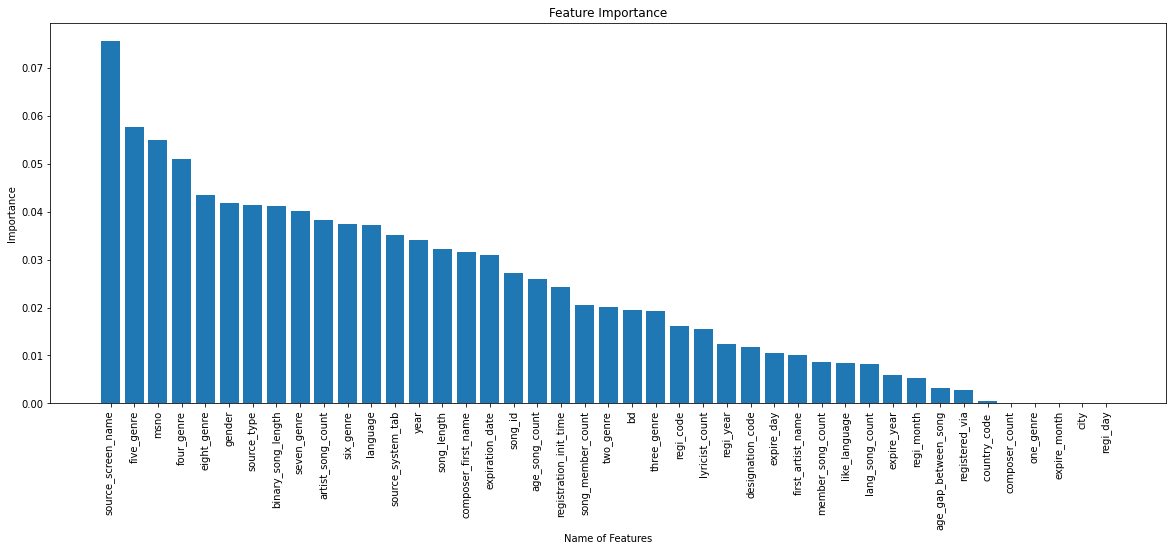

In [ ]:
plt.figure(figsize= (20,7))
plt.bar( rf_feature_impo['features'] , rf_feature_impo['importance'])
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.xlabel('Name of Features')
plt.show()

## Observation
* From graph we see created features have good importance.
* country_code , composer_count , one_genre ,expire_month ,city , regi_day , age_gap_between_song  have very less importance. so we will remove that features.

# **Create 20 features with PCA**

In [ ]:
pca =  PCA(n_components=20)
pca_train = pca.fit_transform(data)

for i in range(20):
    data['pca_feature'+ str(i)] = pca_train[:, i]
    #test_new['pca_feature'+ str(i)]  = pca_test[:, i]

In [ ]:
clf = RandomForestClassifier()
clf.fit(data , y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# get feature importance
feature_impo = clf.feature_importances_.argsort()
features = data.columns[feature_impo]

rf_feature_impo = pd.DataFrame({ 'features' : features,'importance' : clf.feature_importances_ })
rf_feature_impo = rf_feature_impo.sort_values('importance' , ascending=False)
rf_feature_impo.head(3)

,features,importance
60,source_screen_name,0.054622
41,pca_feature7,0.049781
3,five_genre,0.038102


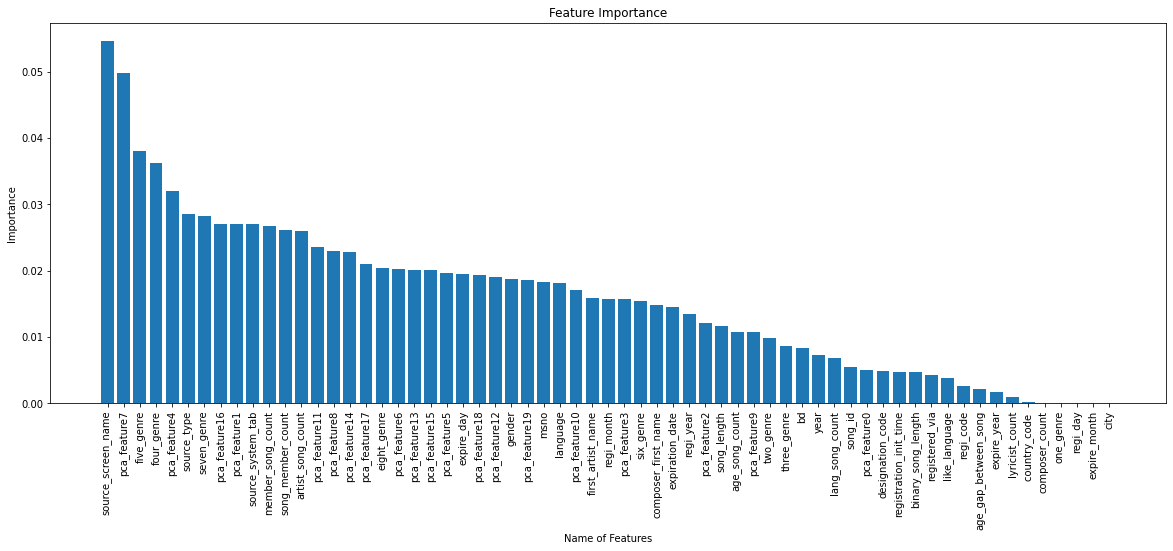

In [ ]:
plt.figure(figsize= (20,7))
plt.bar( rf_feature_impo['features'] , rf_feature_impo['importance'])
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.xlabel('Name of Features')
plt.show()

* We create 20 features form PCA.Train random forest model with all features.
* Here we see that pca features perform well.
* 5 feature are present in top 10 important features. 

# **Create 20 Features with svd**

In [ ]:
svd =  TruncatedSVD(n_components=20 , random_state=42)
svd_train = svd.fit_transform(data)

for i in range(20):
    data['svd_feature'+ str(i)] = svd_train[:, i]
    #test_new['pca_feature'+ str(i)]  = pca_test[:, i]

print(data.shape)

(100000, 83)


In [ ]:
clf = RandomForestClassifier()
clf.fit(data , y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# get feature importance
feature_impo = clf.feature_importances_.argsort()
features = data.columns[feature_impo]

rf_feature_impo = pd.DataFrame({ 'features' : features,'importance' : clf.feature_importances_ })
rf_feature_impo = rf_feature_impo.sort_values('importance' , ascending=False)
rf_feature_impo.head(3)

,features,importance
41,pca_feature3,0.043979
60,pca_feature1,0.037344
3,five_genre,0.037117


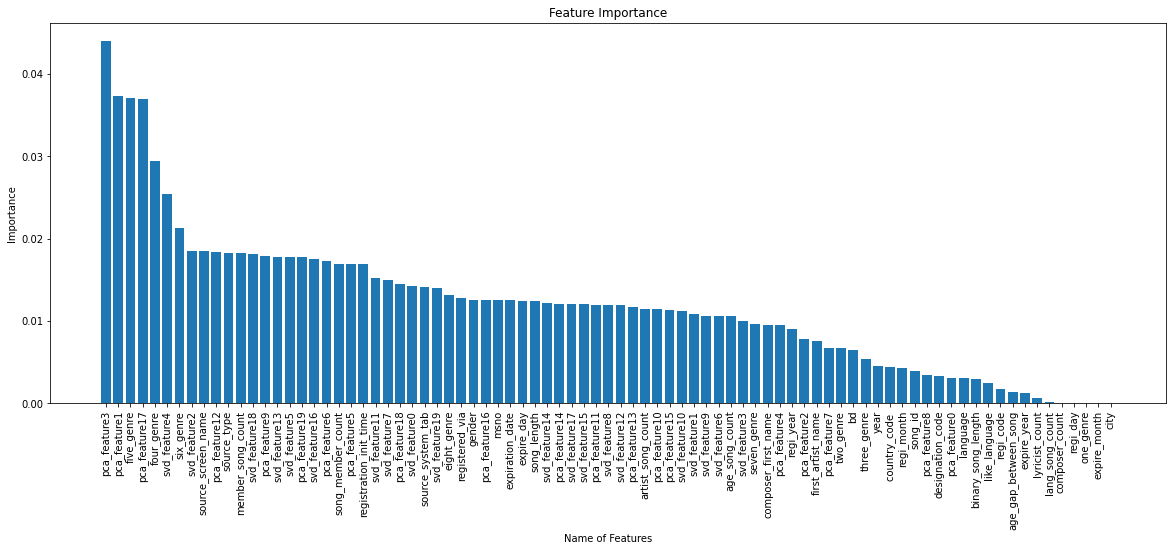

In [ ]:
plt.figure(figsize= (20,7))
plt.bar( rf_feature_impo['features'] , rf_feature_impo['importance'])
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.xlabel('Name of Features')
plt.show()

* Here we are create 20 features with svd.
* As we see in graph pca and svd both features perform well.

# **Conclusion**
* Features that we created by PCA and SVD are perform well.
* country_code , composer_count , one_genre ,expire_month ,city , regi_day , age_gap_between_song and after 3rd genres features perform very poor that may decrease perfomance of model so we will remove that features. 